In [29]:
from itertools import product
from sys import stdout as out
from mip import Model, xsum, minimize, BINARY
from PIL import Image, ImageDraw, ImageFont
import random
from math import cos, sin, pi, sqrt, dist
import warnings
warnings.filterwarnings('ignore')

In [34]:
# Image generation 

def drawarrow(draw, pos, color, width, amp):
    '''This draws the arrowhead'''
    a = 30/180*pi
    pos = ((100+10*pos[0])*amp,
           (100+10*pos[1])*amp,
           (100+10*pos[2])*amp,
           (100+10*pos[3])*amp)
    dist = ((pos[0]-pos[2])**2+(pos[1]-pos[3])**2)**0.5
    midpoint = ((pos[0]+pos[2])/2, (pos[1]+pos[3])/2)
    draw.line(pos, fill=color, width=width)
    vec = (3*amp*(pos[0]-pos[2])/dist, 3*amp*(pos[1]-pos[3])/dist)
    vec1 = (vec[0]*cos(a)-vec[1]*sin(a), vec[0]*sin(a)+vec[1]*cos(a))
    pos1 = midpoint + (midpoint[0]+vec1[0], midpoint[1]+vec1[1])
    vec2 = (vec[0]*cos(a)+vec[1]*sin(a), -vec[0]*sin(a)+vec[1]*cos(a))
    pos2 = midpoint + (midpoint[0]+vec2[0], midpoint[1]+vec2[1])
    draw.line(pos1, fill=color, width=width)
    draw.line(pos2, fill=color, width=width)

def makeresimg(SIZE, node_size, route_width, coordinates, V, Vn, Vc, Ve, K, Kc, Ke, Qc, Qe, rc, re, x, c):
    img = Image.new(mode='RGB', size=(200*SIZE, 200*SIZE), color=0xFFFFFF)
    draw = ImageDraw.Draw(img)
    typeColor = [0x0000FF,   # conventional
                 0x00FF00]    # electrical
    cap = []
    for i in K:
        cap.append([])
        for j in V:
            if j in {0}:
                cap[i].append(0)
            if j in Vn:
                cap[i].append(-1)
            if j in Vc:
                cap[i].append(Qc)
            if j in Ve:
                cap[i].append(Qe)
    for k in Kc:
        cap[k][0] = Qc
        for n in {0}.union(Vc):
            idx = n
            while True:
                nidx = [i for i in V if x[k][idx][i].x >= 0.99]
                if len(nidx) > 1:
                    for m in nidx:
                        sidx = m
                        while True:
                            snidx = [i for i in V if x[k][sidx][i].x >= 0.99][0]
                            pos = tuple(coordinates[sidx]+coordinates[snidx])
                            drawarrow(draw, pos, typeColor[0], route_width, SIZE)
                            if snidx in {0}.union(Vc):
                                break
                            cap[k][snidx] = cap[k][sidx] - c[snidx][sidx]*rc
                            sidx = snidx
                    break
                elif len(nidx) == 1:
                    nidx = nidx[0]
                    pos = tuple(coordinates[idx]+coordinates[nidx])
                    drawarrow(draw, pos, typeColor[0], route_width, SIZE)
                    if nidx in {0}.union(Vc):
                        break
                    cap[k][nidx] = cap[k][idx] - c[nidx][idx]*rc
                    idx = nidx
                else:
                    break
    for k in Ke:
        cap[k][0] = Qe
        for n in {0}.union(Ve):
            idx = n
            while True:
                nidx = [i for i in V if x[k][idx][i].x >= 0.99]
                if len(nidx) > 1:
                    for m in nidx:
                        sidx = m
                        while True:
                            snidx = [i for i in V if x[k][sidx][i].x >= 0.99][0]
                            pos = tuple(coordinates[sidx]+coordinates[snidx])
                            drawarrow(draw, pos, typeColor[1], route_width, SIZE)
                            if snidx in {0}.union(Ve):
                                break
                            cap[k][snidx] = cap[k][sidx] - c[snidx][sidx]*re
                            sidx = snidx
                    break
                elif len(nidx) == 1:
                    nidx = nidx[0]
                    pos = tuple(coordinates[idx]+coordinates[nidx])
                    drawarrow(draw, pos, typeColor[1], route_width, SIZE)
                    if nidx in {0}.union(Ve):
                        break
                    cap[k][nidx] = cap[k][idx] - c[nidx][idx]*re
                    idx = nidx
                else:
                    break
    for i in V:
        print()
        for j in K:
            print('%.1f\t\t' % cap[j][i], end='')
    ncap = [0]*(len(Vn)+1)
    for i in Vn:
        for k in K:
            if cap[k][i] > 0:
                ncap[i] = cap[k][i]
                break
    draw.rectangle(((100-node_size)*SIZE,
                    (100-node_size)*SIZE,
                    (100+node_size)*SIZE,
                    (100+node_size)*SIZE), 
                    fill='white', outline='black', width=5)
    for i in Vn:
        pos = ((100 - node_size + 10*coordinates[i][0])*SIZE, 
               (100 - node_size + 10*coordinates[i][1])*SIZE, 
               (100 + node_size + 10*coordinates[i][0])*SIZE, 
               (100 + node_size + 10*coordinates[i][1])*SIZE)
        draw.ellipse(pos, fill='white', outline='black', width=5)

        # Inside the makeresimg function, where you're calculating text size
        captex = "{:.1f}".format(ncap[i])
        text_font = ImageFont.load_default()  # Use default font
        text_bbox = draw.textbbox((0, 0), captex, font=text_font)
        w, h = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

        # Draw text at the specified position
        draw.text(((100 + 10 * coordinates[i][0]) * SIZE - w / 2,
                   (100 + 10 * coordinates[i][1]) * SIZE - h / 2), captex, fill='black', font=text_font)
        draw.text(((100+10*coordinates[i][0])*SIZE, 
                   (100+10*coordinates[i][1]-3)*SIZE-h/2), str(i), fill='black')

    for i in Vc:
        pos = ((100 - node_size + 10*coordinates[i][0])*SIZE, 
               (100 - node_size + 10*coordinates[i][1])*SIZE, 
               (100 + node_size + 10*coordinates[i][0])*SIZE, 
               (100 + node_size + 10*coordinates[i][1])*SIZE)
        draw.ellipse(pos, fill='white', outline=typeColor[0], width=5)
    for i in Ve:
        pos = ((100 - node_size + 10*coordinates[i][0])*SIZE, 
               (100 - node_size + 10*coordinates[i][1])*SIZE, 
               (100 + node_size + 10*coordinates[i][0])*SIZE, 
               (100 + node_size + 10*coordinates[i][1])*SIZE)
        draw.ellipse(pos, fill='white', outline=typeColor[1], width=5)
    return img

def makerawimg(SIZE, node_size, route_width, coordinates):
    print("no img")


In [6]:
# Enter the Assumptions

# N     : Number of customer nodes
N = 8
# kc    : Number of conventional vehicles

kc = 2
# ke    : Number of electric vehicles
ke = 2

# Sc    : Number of fuel stations
Sc= 2
# Se    : Number of charging stations
Se = 2

# Qc    : Maximum fuel capacity of conventional vehicles
Qc = 20
# Qe    : Maximum battery capacity of electric vehicles
Qe = 15


# rc    : Amount of fuel consumed per unit distance traveled
rc = 1
# re    : Amount of battery consumed per unit distance traveled
re = 1

# (0, 0) depot node
coordinates = [[0, 0]] 

In [7]:
# Generate random coordinates

# Generate N customer nodes at random coordinates
for i in range(N):
    #coordinates.append([20*random.random()-10, 20*random.random()-10])
    r = 7*random.random()+3
    t = random.random()
    #r = 6.5
    #t = 1/N*(i+0.5)
    coordinates.append([r*cos(t*2*pi), r*sin(t*2*pi)])
    #coordinates.append([r*cos(i/N*2*pi), r*sin(i/N*2*pi)])

# Specify the positions of Sc fuel stations
for i in range(Sc):
    r = 5.5
    t = 2*pi*(1/Sc*(i)+1/4)
    coordinates.append([r*cos(t), r*sin(t)])

# Specify the positions of Se charging stations
for i in range(Se):
    r = 3.5
    t = 2*pi/Se*(i)
    coordinates.append([r*cos(t), r*sin(t)])


In [11]:
coordinates

[[0, 0],
 [-7.174666468944682, 0.3182383343854003],
 [-3.1495450965692977, -5.790917215853225],
 [4.250217460492354, -1.385358032407116],
 [-1.2749597069979377, 5.230955894240892],
 [-4.608834509639926, 2.865407725815486],
 [-0.3464945185320165, 4.663304792961827],
 [3.0397718184632634, 8.879286898676213],
 [3.157552016937361, -9.35043214072214],
 [3.3677786976552215e-16, 5.5],
 [-1.0103336092965664e-15, -5.5],
 [3.5, 0.0],
 [-3.5, 4.286263797015736e-16]]

In [8]:
# =====================           Sets          ===================== 
# V     : Set of all nodes
# Vn    : Set of customer nodes
# Vc    : Set of fuel stations
# Ve    : Set of charging stations
V = set(range(1+N+Sc+Se))
Vn = set(range(1, 1+N))
Vc = set(range(1+N, 1+N+Sc))
Ve = set(range(1+N+Sc, 1+N+Sc+Se))
# K     : Set of all vehicles
# Kc    : Set of conventional vehicles
# Ke    : Set of electric vehicles
K = set(range(kc+ke))
Kc = set(range(kc))
Ke = set(range(kc, kc+ke))

# Distances matrix
c = []
for i in V:
    c.append([])
    for j in V:
        c[i].append(dist(coordinates[i], coordinates[j]))


In [17]:
c

[[0.0,
  7.181720864672446,
  6.591991847400069,
  4.470298126459687,
  5.384089692971487,
  5.426962038969037,
  4.676159753840055,
  9.38519837495865,
  9.869180105657957,
  5.5,
  5.5,
  3.5,
  3.5],
 [7.181720864672446,
  0.0,
  7.315967714483471,
  11.551199651207545,
  7.677325947220988,
  3.6154620108677675,
  8.09342540052407,
  13.327651782944029,
  14.150545134241963,
  8.850225584686084,
  9.23730135138564,
  10.67940915316406,
  3.688420975899955],
 [6.591991847400069,
  7.315967714483471,
  0.0,
  8.61193576495656,
  11.180150143795483,
  8.778467240176717,
  10.823486053607134,
  15.922390920859362,
  7.242211022855422,
  11.721964250524502,
  3.162952282568217,
  8.817662512943782,
  5.80151194433002],
 [4.470298126459687,
  11.551199651207545,
  8.61193576495656,
  0.0,
  8.619929971183781,
  9.826078126128573,
  7.597110173816511,
  10.335768680341191,
  8.039671841716526,
  8.091508122464393,
  5.915625662848412,
  1.5754501312267908,
  7.873060876360316],
 [5.3840896

In [18]:
# ===================== Parameters & Variables =====================

# n: Total number of nodes
n = len(V)

model = Model()

x = [[[model.add_var(var_type=BINARY) for j in V] for i in V] for k in K]

# y to remove closed paths not connected to the depot
y = [[model.add_var() for i in V] for k in K]

# u1 represents the initial battery level, and u2 represents the final battery level for each vehicle k at node i
u1 = [[model.add_var() for i in V] for k in K]
u2 = [[model.add_var() for i in V] for k in K]


In [19]:
# =====================   Objective Function   =====================

model.objective = minimize(xsum(c[i][j]*x[k][i][j] for k in K for i in V for j in V))

In [20]:
# =====================       Subject-to       =====================

# For each route k, only one outgoing and one incoming edge from the depot
for k in K:
    model += xsum(x[k][0][j] for j in V-{0}) <= 1
    model += xsum(x[k][i][0] for i in V-{0}) <= 1

# For each customer node, exactly one outgoing edge for each route k
for i in Vn:
    model += xsum(x[k][i][j] for k in K for j in V - {i}) == 1

# For each customer node, exactly one incoming edge for each route k
for j in Vn:
    model += xsum(x[k][i][j] for k in K for i in V - {j}) == 1

# Maximum initial battery or fuel for vehicles leaving the depot
for k in Kc:
    model += u1[k][0] == Qc
for k in Ke:
    model += u1[k][0] == Qe

# Prohibition on visiting other charging stations for conventional vehicles
for k in Kc:
    for i in Ve:
        for j in V:
            model += x[k][i][j] == 0
            model += x[k][j][i] == 0

# Prohibition on visiting other fuel stations for electric vehicles
for k in Ke:
    for i in Vc:
        for j in V:
            model += x[k][i][j] == 0
            model += x[k][j][i] == 0

# Maximum initial battery or fuel for vehicles leaving other charging and fuel stations
for k in Kc:
    for i in Vc:
        model += u1[k][i] == Qc
for k in Ke:
    for i in Ve:
        model += u1[k][i] == Qe

# Ensure that the battery levels are within the valid range at each node and time point
for i in V:
    for k in Kc:
        model += u1[k][i] >= 0
        model += u1[k][i] <= Qc
        model += u2[k][i] >= 0
        model += u2[k][i] <= Qc
    for k in Ke:
        model += u1[k][i] >= 0
        model += u1[k][i] <= Qe
        model += u2[k][i] >= 0
        model += u2[k][i] <= Qe

# Ensure that the number of incoming and outgoing vehicles at each node is equal for each route k
for k in K:
    for i in V:
        model += xsum(x[k][i][j] for j in V - {i}) == xsum(x[k][j][i] for j in V - {i})

# Sub-tour elimination constraints
for k in K:
    for (i,j) in product(V-{0}, V-{0}):
        if i != j:
            model += y[k][i] - (n+1)*x[k][i][j] >= y[k][j] - n

# Battery and fuel consumption
for (i, j) in product(V, V):
    if i != j:
        for k in Kc:
            model += u1[k][i] - rc*c[i][j]*x[k][i][j] + Qc*(1 - x[k][i][j]) >= u2[k][j]
        for k in Ke:
            model += u1[k][i] - re*c[i][j]*x[k][i][j] + Qe*(1 - x[k][i][j]) >= u2[k][j]

# Ensure that the initial and final battery levels are equal for each customer node (excluding depot and stations)
for k in K:
    for i in Vn:
        model += u1[k][i] == u2[k][i]


In [21]:
# =====================       모델 풀이       =====================
model.optimize()

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 1012 (-676) rows, 520 (-312) columns and 4072 (-1988) elements
Clp1000I sum of infeasibilities 2.102e-05 - average 2.07707e-08, 338 fixed columns
Coin0506I Presolve 686 (-326) rows, 180 (-340) columns and 1791 (-2281) elements
Clp0029I End of values pass after 180 iterations
Clp0014I Perturbing problem by 0.001% of 5.900261 - largest nonzero change 4.6883825e-05 ( 0.0012452293%) - largest zero change 2.8835962e-05
Clp0000I Optimal - objective value 36.133344
Clp0000I Optimal - objective value 36.133344
Coin0511I After Postsolve, objective 36.133344, infeasibilities - dual 0 (0), primal 0 (0)
Clp0014I Perturbing problem by 0.001% of 4.1456857 - largest nonzero change 2.6642225e-05 ( 0.00073052058%) - largest zero change 2.8835962e-05
Clp0000I Optimal - objective value 36.133344
Clp0000I Optimal - objective value 

<OptimizationStatus.OPTIMAL: 0>

******* Route with total distance 51.6038 *******
 0	0.0	0.0
 1	-7.2	0.3
 2	-3.1	-5.8
 3	4.3	-1.4
 4	-1.3	5.2
 5	-4.6	2.9
 6	-0.3	4.7
 7	3.0	8.9
 8	3.2	-9.4
 9	0.0	5.5
10	-0.0	-5.5
11	3.5	0.0
12	-3.5	0.0


0.0	7.2	6.6	4.5	5.4	5.4	4.7	9.4	9.9	5.5	5.5	3.5	3.5	
7.2	0.0	7.3	11.6	7.7	3.6	8.1	13.3	14.2	8.9	9.2	10.7	3.7	
6.6	7.3	0.0	8.6	11.2	8.8	10.8	15.9	7.2	11.7	3.2	8.8	5.8	
4.5	11.6	8.6	0.0	8.6	9.8	7.6	10.3	8.0	8.1	5.9	1.6	7.9	
5.4	7.7	11.2	8.6	0.0	4.1	1.1	5.7	15.2	1.3	10.8	7.1	5.7	
5.4	3.6	8.8	9.8	4.1	0.0	4.6	9.7	14.5	5.3	9.6	8.6	3.1	
4.7	8.1	10.8	7.6	1.1	4.6	0.0	5.4	14.4	0.9	10.2	6.0	5.6	
9.4	13.3	15.9	10.3	5.7	9.7	5.4	0.0	18.2	4.5	14.7	8.9	11.0	
9.9	14.2	7.2	8.0	15.2	14.5	14.4	18.2	0.0	15.2	5.0	9.4	11.5	
5.5	8.9	11.7	8.1	1.3	5.3	0.9	4.5	15.2	0.0	11.0	6.5	6.5	
5.5	9.2	3.2	5.9	10.8	9.6	10.2	14.7	5.0	11.0	0.0	6.5	6.5	
3.5	10.7	8.8	1.6	7.1	8.6	6.0	8.9	9.4	6.5	6.5	0.0	7.0	
3.5	3.7	5.8	7.9	5.7	3.1	5.6	11.0	11.5	6.5	6.5	7.0	0.0	

20.0		20.0		15.0		15.0		
11.0		-1.0		-1.0		-1.0		
3.7		-1.0		-1.

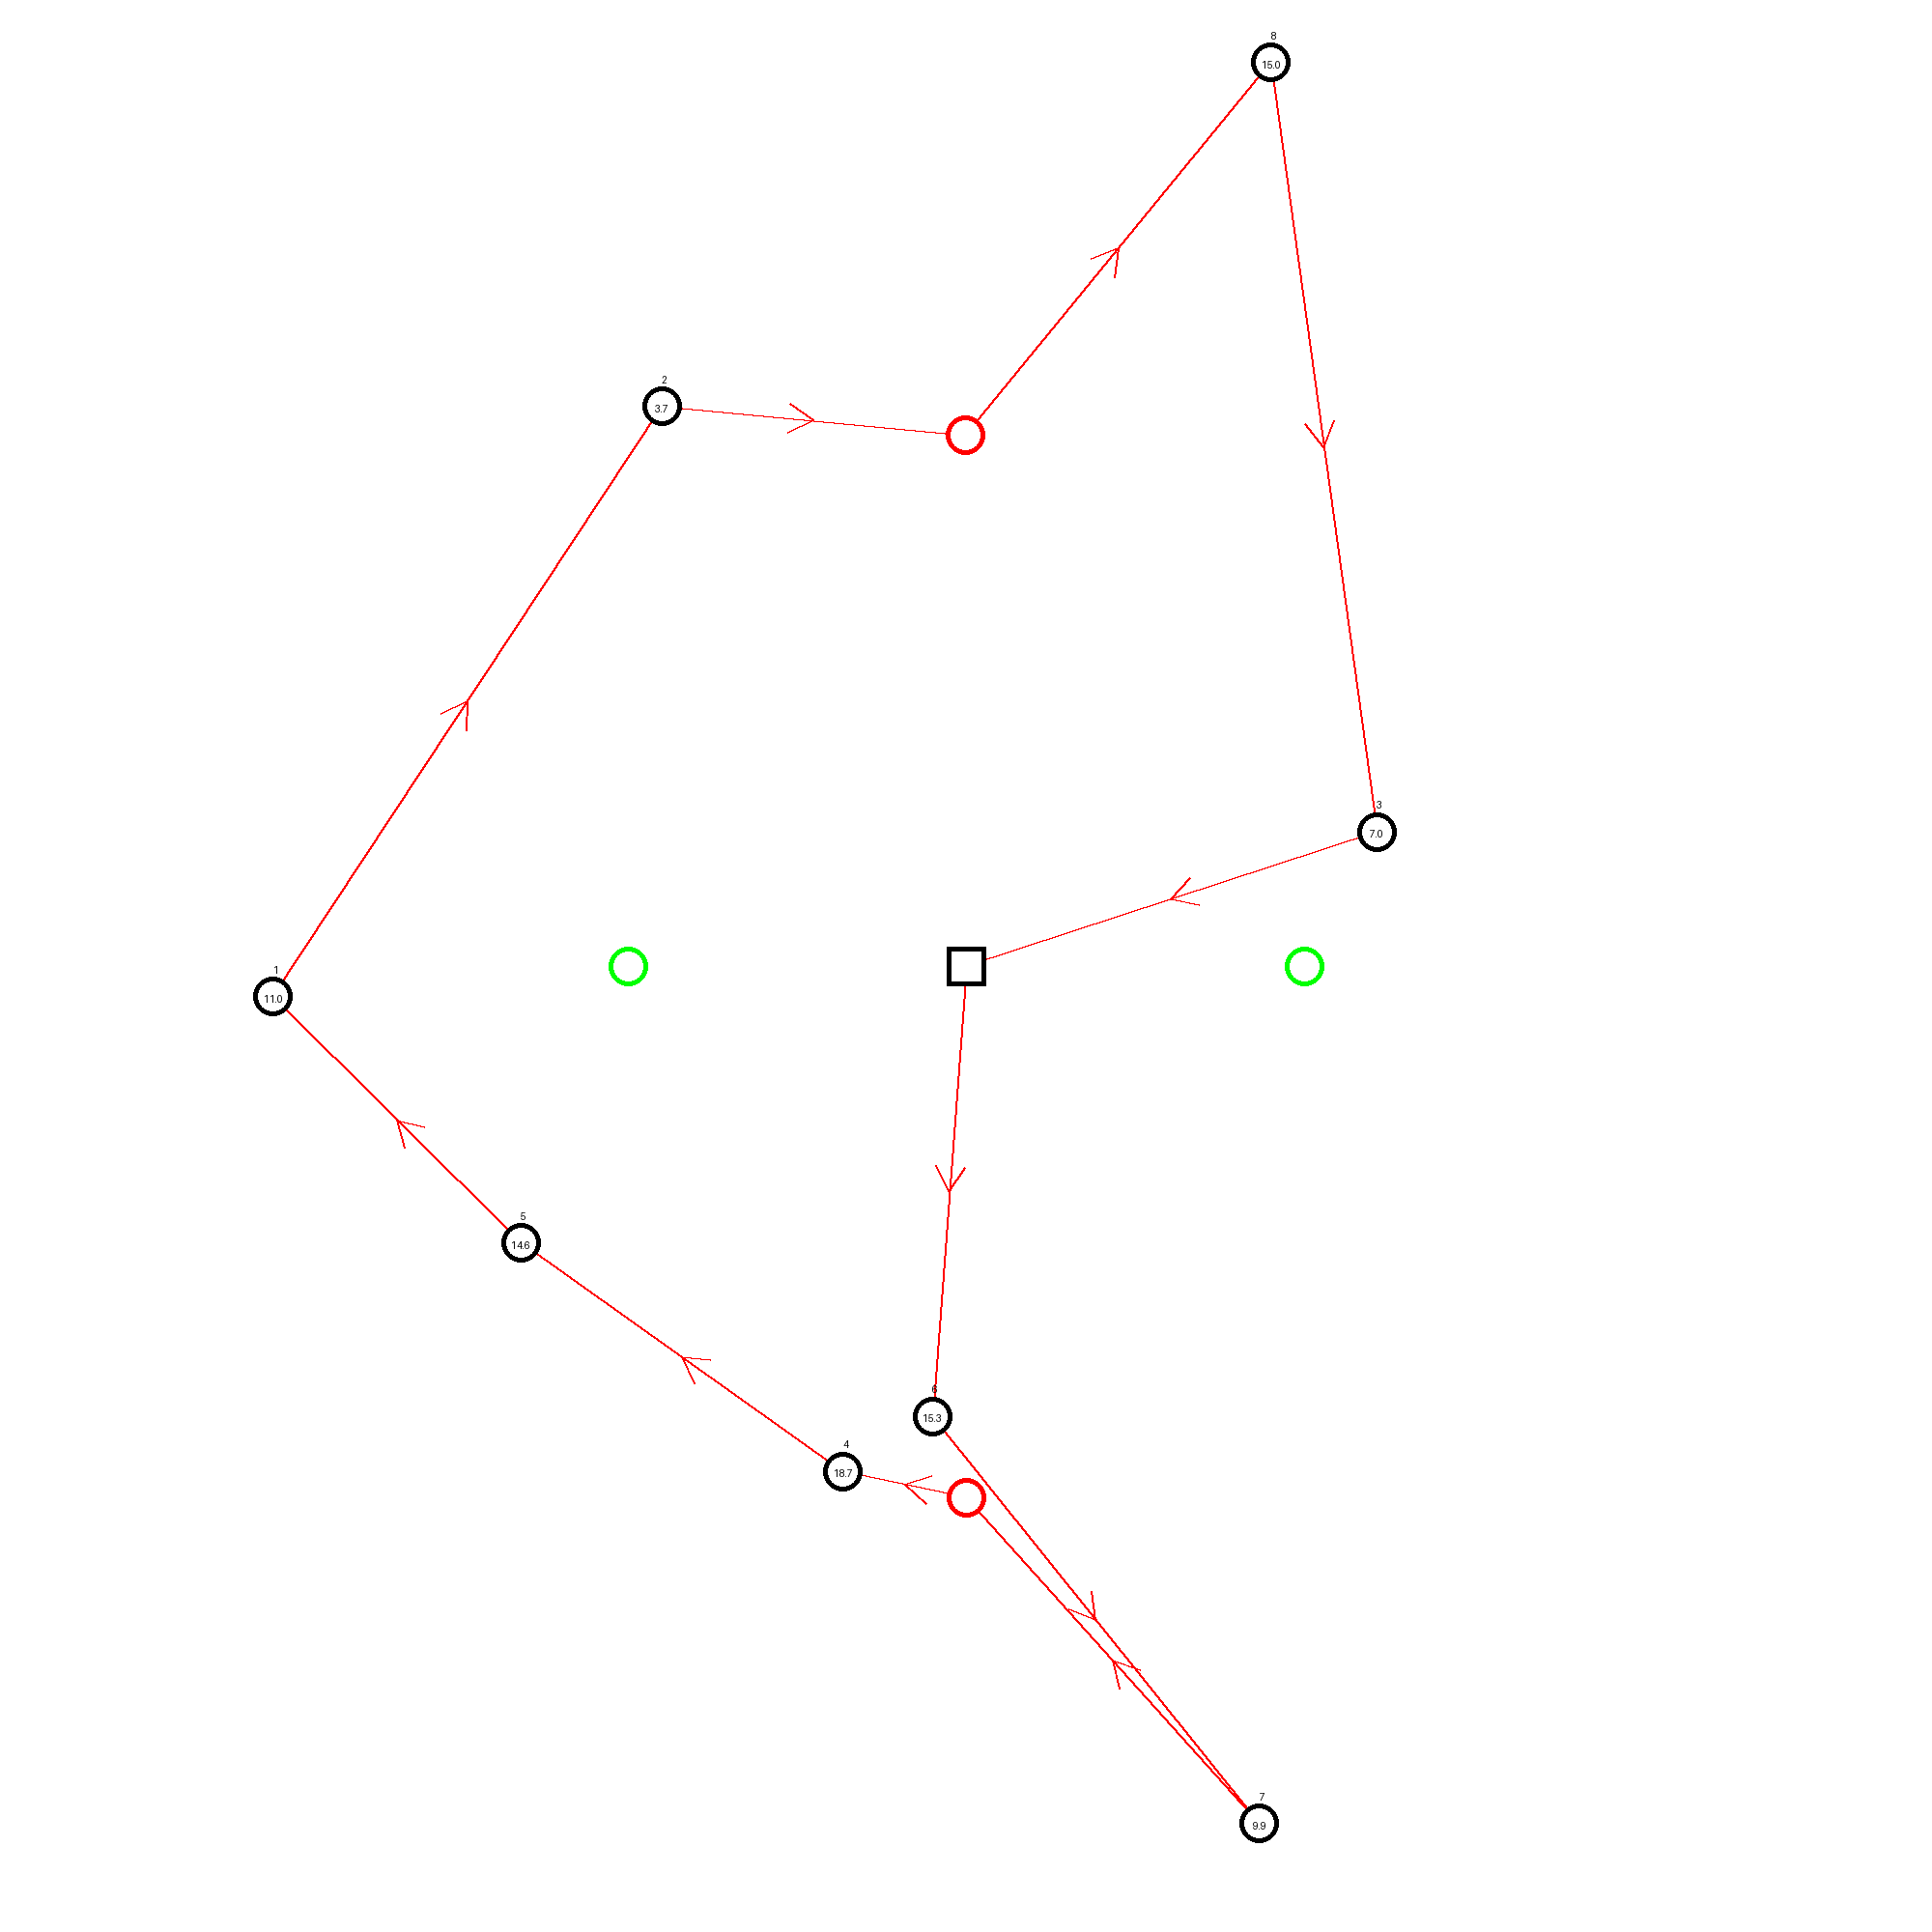

In [35]:
# =====================      Image Creation      =====================
SIZE = 10
node_size = 2
route_width = 2

if model.num_solutions:
    out.write('******* Route with total distance %g *******'%(model.objective_value))
    print()
    for i in V:
        print('%2d\t%.1f\t%.1f'%(i, coordinates[i][0], coordinates[i][1]))
    print()
    for i in V:
        print()
        for j in V:
            print('%.1f\t'%c[i][j], end='')
    print()
    res_img = makeresimg(SIZE, node_size, route_width, coordinates, V, Vn, Vc, Ve, K, Kc, Ke, Qc, Qe, rc, re, x, c)
    res_img.show()
    res_img.save('result-EVRPMF.png')
else:
    print("NO ANSWER")
    res_img = makerawimg()
